## Imports

In [1]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
from torchvision import models
import torch.nn as nn
from torchvision.transforms import v2
import json

In [ ]:
import spoofdet.config as config
from spoofdet.yolo.model_utils import get_transform_pipeline, evaluate_model, train_model, checkImage, checkAugmentedImage, create_subset, checkDatasetDistribution, display_train_result, save_results, analyze_spoof_types, analyze_dataset_spoof_distribution, display_params
from spoofdet.dataset import CelebASpoofDataset

## randomizer

In [3]:
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SoftTargetFocalLoss(nn.Module):
    def __init__(self, alpha=[0.25, 0.75], gamma=2.0, reduction='mean'):
        """
        alpha: list of weights for each class (e.g., [weight_for_class_0, weight_for_class_1])
        """
        super(SoftTargetFocalLoss, self).__init__()
        self.alpha = torch.tensor(alpha) if alpha is not None else None
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        # inputs: (N, C) - Logits (Raw scores)
        # targets: (N, C) - Soft Labels from MixUp (e.g., [0.2, 0.8])
        
        # 1. Convert Logits to Probabilities
        probs = F.softmax(inputs, dim=1)
        
        # 2. Calculate the "Focal Term" (1 - p)^gamma
        # Note: We compute log_probs for numerical stability
        log_probs = F.log_softmax(inputs, dim=1)
        focal_term = (1 - probs) ** self.gamma
        
        # 3. Apply Alpha Weighting (Element-wise)
        if self.alpha is not None:
            if self.alpha.device != inputs.device:
                self.alpha = self.alpha.to(inputs.device)
            # Expand alpha to batch size
            alpha_t = self.alpha.expand(inputs.size(0), -1) 
            loss_components = -1 * targets * alpha_t * focal_term * log_probs
        else:
            loss_components = -1 * targets * focal_term * log_probs

        # 4. Sum across classes, then reduce across batch
        # Summing over dim=1 (classes) captures the mix of both classes
        loss = loss_components.sum(dim=1)

        if self.reduction == 'mean':
            return loss.mean()
        elif self.reduction == 'sum':
            return loss.sum()
        else:
            return loss

## preparation


In [5]:
import multiprocessing
from torch.utils.data import Subset

PARAM_MULTIPLIER = 1

MODEL_NAME = "yolov8n-cls"
BATCH_SIZE= 64 * PARAM_MULTIPLIER


EPOCHS = config.EPOCHS
EARLY_STOPPING_LIMIT = config.EARLY_STOPPING_LIMIT
TARGET_SIZE = 416
#TARGET_SIZE = config.TARGET_SIZE
LEARNING_RATE = 1e-3 * PARAM_MULTIPLIER
WEIGHT_DECAY = 5e-2 * PARAM_MULTIPLIER

WORKERS = 4

SPOOF_PERCENT = 0.5
TRAIN_IMG_COUNT = 10000
VAL_IMG_COUNT = int(TRAIN_IMG_COUNT * 0.2)  
# VAL_IMG_COUNT = 1000
TEST_IMG_COUNT = int(TRAIN_IMG_COUNT * 0.1)  



## Model


In [6]:
from ultralytics import YOLO

yolo_model = YOLO(f'{MODEL_NAME}.pt')

# unfreeze
model = yolo_model.model
for param in model.parameters():
    param.requires_grad = True

# Adjust the final layer for 2 classes (Live/Spoof)
classify_head = model.model[-1]

num_features = classify_head.linear.in_features
classify_head.linear = nn.Sequential(
    nn.Linear(num_features, 128),
    nn.BatchNorm1d(128),  
    nn.ReLU(),
    nn.Dropout(0.3),    
    nn.Linear(128, 2)
)

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
bbox_lookup = "../bbox_lookup.json"

num_cpus = multiprocessing.cpu_count()

class_weights = torch.tensor([1.0, 1.0]).to(device)
criterion = SoftTargetFocalLoss(alpha=None, gamma=2.0, reduction='mean')
#criterion = nn.CrossEntropyLoss(weight=class_weights, label_smoothing=0.1)
optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS, eta_min=1e-6)

device

device(type='cuda')

In [8]:
# Add this cell before the training cell

class ModelWrapper(nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model
    
    def forward(self, x):
        output = self.model(x)
        # YOLOv8 returns tuple, extract logits
        if isinstance(output, tuple):
            return output[0]
        return output

# Wrap the model
model = ModelWrapper(model)
model.to(device)

ModelWrapper(
  (model): ClassificationModel(
    (model): Sequential(
      (0): Conv(
        (conv): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (1): Conv(
        (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (2): C2f(
        (cv1): Conv(
          (conv): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (act): SiLU(inplace=True)
        )
        (cv2): Conv(
          (conv): Conv2d(48, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_

In [9]:
gpu_transforms_train, gpu_transforms_val = get_transform_pipeline(device=device, target_size=TARGET_SIZE)

In [10]:


all_ds = CelebASpoofDataset(
    root_dir=config.ROOT_DIR,
    json_label_path=config.TRAIN_JSON,
    bbox_json_path=bbox_lookup,
    target_size = TARGET_SIZE,
    bbox_original_size = config.BBOX_ORGINAL_SIZE
)

test_ds = CelebASpoofDataset(
    root_dir=config.ROOT_DIR,
    json_label_path=config.TEST_JSON,
    bbox_json_path=bbox_lookup,
    target_size = TARGET_SIZE,
    bbox_original_size = config.BBOX_ORGINAL_SIZE
)

# Create train/val split without overlap



Loading BBox Cache into RAM...
Loading BBox Cache into RAM...


In [11]:
def split_celeba_json_by_subject(json_path, val_split=0.5):
    """
    Parses CelebA-Spoof JSON and creates Subject-Disjoint indices.
    """
    with open(json_path, 'r') as f:
        data = json.load(f) # Assuming list of dicts or maps
        
    # 1. Group indices by Subject ID
    # CelebA-Spoof paths usually look like: "Data/train/Subject_ID/..."
    subject_indices = {}
    
    # Check your JSON structure. Assuming keys are file paths or it's a list
    # If it's a dict { "path/to/img": label }:
    paths = list(data.keys()) 
    
    for idx, path in enumerate(paths):
        # Extract Subject ID (e.g., from "Data/train/12345/live/001.jpg")
        # Adjust split logic based on your actual path structure
        parts = path.split('/')
        if len(parts) > 2:
            subj_id = parts[-3] # or parts[2], verify your path structure!
        else:
            subj_id = "unknown"

        if subj_id not in subject_indices:
            subject_indices[subj_id] = []
        subject_indices[subj_id].append(idx)
        
    # 2. Split the SUBJECTS
    all_subjects = list(subject_indices.keys())
    # Shuffle subjects to ensure random selection
    np.random.shuffle(all_subjects)
    
    split_point = int(len(all_subjects) * (1 - val_split))
    train_subjs = all_subjects[:split_point]
    val_subjs = all_subjects[split_point:]
    
    # 3. Collect Indices
    train_indices = []
    val_indices = []
    
    for subj in train_subjs:
        train_indices.extend(subject_indices[subj])
        
    for subj in val_subjs:
        val_indices.extend(subject_indices[subj])
        
    return train_indices, val_indices

t_idx, v_idx = split_celeba_json_by_subject(config.TRAIN_JSON)
train_ds = Subset(all_ds, t_idx)
val_ds = Subset(all_ds, v_idx)

In [12]:
len(train_ds)

247020

In [13]:
np.random.seed(seed)

small_train_ds = create_subset(train_ds, total_size=TRAIN_IMG_COUNT, spoof_percent=SPOOF_PERCENT)

 Scanning specific indices for class balance...
 Found in this split: 81077 Live | 165943 Spoof


In [14]:


small_val_ds = create_subset(val_ds, total_size=VAL_IMG_COUNT, spoof_percent=SPOOF_PERCENT)
small_test_ds = create_subset(test_ds, total_size=TEST_IMG_COUNT)
print(f"Created Balanced Train: {len(small_train_ds)} images")

 Scanning specific indices for class balance...
 Found in this split: 81385 Live | 166000 Spoof
 Scanning specific indices for class balance...
 Found in this split: 19923 Live | 47247 Spoof
Created Balanced Train: 10000 images


In [15]:
len(small_train_ds)

10000

In [16]:
len(small_val_ds)

2000

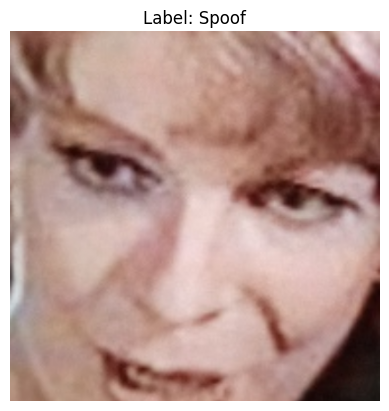

In [17]:

# 1 = spoof  0 = live 
checkImage(small_train_ds, 210)

In [18]:
# # check distribution of live and spoof in small_test_ds
# checkDatasetDistribution(small_test_ds)

In [19]:
# checkDatasetDistribution(small_train_ds)

In [20]:
# checkDatasetDistribution(small_val_ds)

## Data Loader

In [21]:
from torch.utils.data import DataLoader
small_train_loader = DataLoader(small_train_ds, 
                                batch_size=BATCH_SIZE, 
                                shuffle=True,
                                num_workers=2,
                                pin_memory=True,
                                persistent_workers=True
          
                   
)
small_val_loader = DataLoader(small_val_ds, 
                              batch_size=BATCH_SIZE,
                              shuffle=False,
                              num_workers=2,
                              pin_memory=True,
                              persistent_workers=True
                
                    
)
small_test_loader = DataLoader(small_test_ds, 
                               batch_size=BATCH_SIZE, 
                               shuffle=False,
                                num_workers=2,
                                pin_memory=True,
                                persistent_workers=True
                                )

In [22]:
# def verify_weights(dataset):
#     # 1. Grab a sample you KNOW is Live
#     # (You might need to check your folders/JSON to find a specific filename or index)
#     # For now, let's just check the first item and print what it is.
#     img, label = dataset[0] 
    
#     print(f"Sample Index 0 has Label: {label}")
    
#     # Logic check:
#     # If your JSON says 0 = Live and 1 = Spoof
#     if label == 0:
#         print("Class 0 appears to be Live.")
#     elif label == 1:
#         print("Class 1 appears to be Spoof.")
        
#     print("-" * 30)
    
#     # 2. Define Weights
#     # If 0 is Live, we want the FIRST weight to be small (1.0)
#     # If 1 is Spoof, we want the SECOND weight to be large (3.0)
#     print("Recommended Weights based on standard (0=Live, 1=Spoof):")
#     print("torch.tensor([1.0, 3.0])") 
#     print(" -> Index 0 (Live) gets weight 1.0")
#     print(" -> Index 1 (Spoof) gets weight 3.0 (Focus here!)")

# verify_weights(small_train_ds)

In [23]:
sample_img, sample_label = small_train_ds[0]
sample_img.shape, sample_label

(torch.Size([3, 416, 416]), tensor(0))

In [24]:
# Add a test cell after the ModelWrapper to verify it works

def test_model_wrapper(model, small_train_ds, device):
    model.eval()
    print("Testing ModelWrapper...")
    test_img, _ = small_train_ds[0]
    test_img = test_img.unsqueeze(0).to(device)
    test_img = test_img.float() / 255.0
    output = model(test_img)
    print(f"Output type: {type(output)}")
    print(f"Output shape: {output.shape if isinstance(output, torch.Tensor) else 'Not a tensor!'}")
    print(f"Is tensor: {isinstance(output, torch.Tensor)}")

test_model_wrapper(model, small_train_ds, device)

Testing ModelWrapper...
Output type: <class 'torch.Tensor'>
Output shape: torch.Size([1, 2])
Is tensor: True


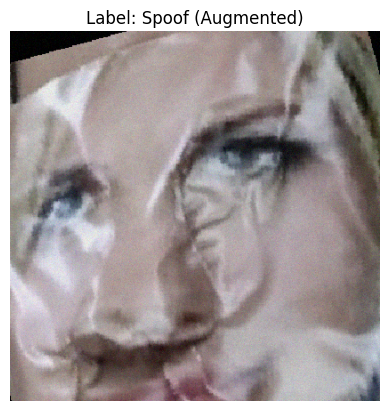

In [25]:
checkAugmentedImage(small_train_ds, 2, gpu_transforms=gpu_transforms_train)

In [27]:
params = display_params(model_name=MODEL_NAME, lr=LEARNING_RATE, batch_size=BATCH_SIZE, weight_decay=WEIGHT_DECAY, epochs=EPOCHS, early_stopping_limit=EARLY_STOPPING_LIMIT, target_size=TARGET_SIZE, train_size=len(small_train_ds), val_size=len(small_val_ds))

Training Configuration:
model name: yolov8n-cls
 Batch Size: 64
 Learning Rate: 0.001
 Weight Decay: 0.05
 Epochs: 200
 Early Stopping Limit: 30
 Target Size: 416
 Train Size: 10000
 Validation Size: 2000


## Train

In [28]:
model, history = train_model(model=model, 
                             device=device, 
                             train_loader=small_train_loader, 
                             val_loader=small_val_loader,      
                             criterion=criterion, 
                             optimizer=optimizer, 
                             epochs=EPOCHS, 
                             early_stopping_limit=EARLY_STOPPING_LIMIT,
                             train_transforms=gpu_transforms_train,
                             val_transforms=gpu_transforms_val,
                             profiler_log_name=MODEL_NAME,
                             scheduler=scheduler
                             )

Epoch [1/200] | Time: 1m 14s Train Loss: 0.1333 | Val Loss: 0.1832 | Val Precision: 51.55% | Val Accuracy: 53.00% | Val Recall: 99.70% | Val F1: 67.96%
Scheduler Step! New LR: 0.00099994  -> New best model saved!
Epoch [2/200] | Time: 0m 53s Train Loss: 0.1131 | Val Loss: 0.1815 | Val Precision: 51.45% | Val Accuracy: 52.80% | Val Recall: 99.40% | Val F1: 67.80%
Scheduler Step! New LR: 0.00099975  -> No improvement. Counter: 1/30
Epoch [3/200] | Time: 0m 58s Train Loss: 0.1022 | Val Loss: 0.1877 | Val Precision: 52.33% | Val Accuracy: 54.35% | Val Recall: 97.70% | Val F1: 68.15%
Scheduler Step! New LR: 0.00099945  -> New best model saved!
Epoch [4/200] | Time: 0m 47s Train Loss: 0.1038 | Val Loss: 0.2277 | Val Precision: 51.05% | Val Accuracy: 52.05% | Val Recall: 99.30% | Val F1: 67.44%
Scheduler Step! New LR: 0.00099901  -> No improvement. Counter: 1/30
Epoch [5/200] | Time: 0m 37s Train Loss: 0.0964 | Val Loss: 0.1632 | Val Precision: 61.37% | Val Accuracy: 62.15% | Val Recall: 65.6

D:\JoshFile\Github\spoofing-recognition\src\spoofdet\model_utils.py:411: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig_loss.show()
D:\JoshFile\Github\spoofing-recognition\src\spoofdet\model_utils.py:421: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig_precision.show()


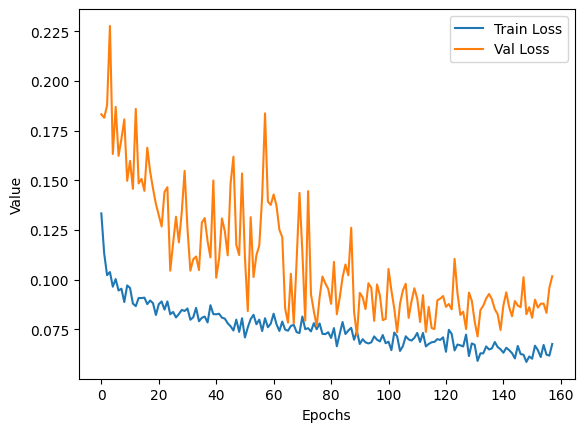

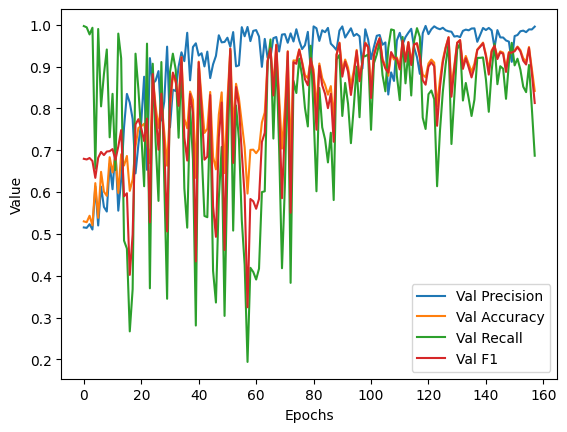

In [29]:




train_loss_fig, precision_fig = display_train_result(history)

## test


Confusion Matrix:
         Predicted Live | Predicted Spoof
Live           492     |          8
Spoof          107     |        393


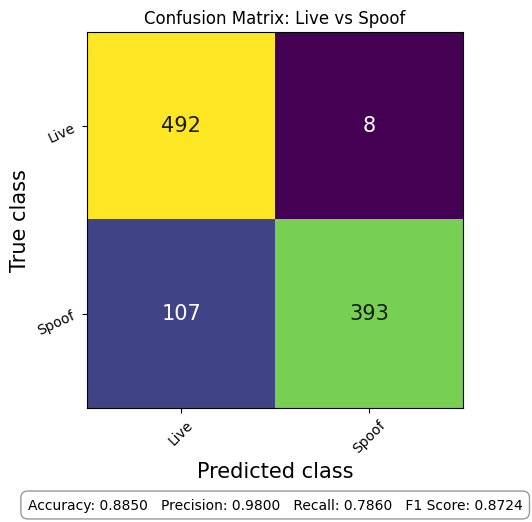

Accuracy: 0.8850
Precision: 0.9800
Recall:    0.7860
F1 Score:  0.8724


In [30]:
test_loader = DataLoader(test_ds, 
                               batch_size=BATCH_SIZE, 
                               shuffle=False,
                                num_workers=2,
                                pin_memory=True,
                                persistent_workers=True
                                )
confusion_matrix, accuracy, precision, recall, f1 = evaluate_model(model=model, dataloader=small_test_loader, device=device, val_transforms=gpu_transforms_val)


Confusion Matrix:
         Predicted Live | Predicted Spoof
Live         19511     |        412
Spoof        10413     |      36834


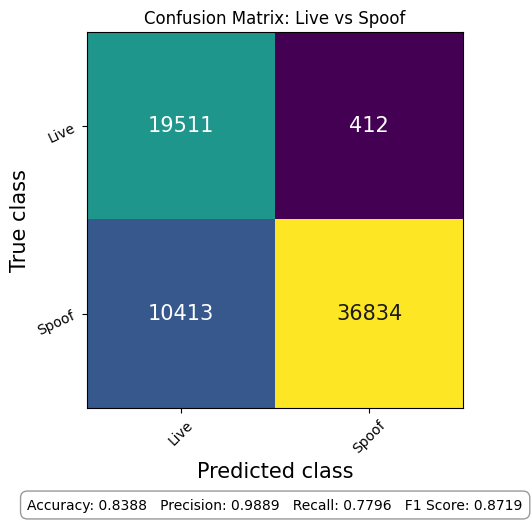

Accuracy: 0.8388
Precision: 0.9889
Recall:    0.7796
F1 Score:  0.8719


In [31]:
test_loader = DataLoader(test_ds, 
                               batch_size=BATCH_SIZE, 
                               shuffle=False,
                                num_workers=2,
                                pin_memory=True,
                                persistent_workers=True
                                )
confusion_matrix1, accuracy1, precision1, recall1, f11 = evaluate_model(model=model, dataloader=test_loader, device=device, val_transforms=gpu_transforms_val)

In [ ]:


save_results(model=model, confusion_matrix_fig=confusion_matrix, train_loss_fig=train_loss_fig, precision_fig=precision_fig, params=params, spoof_fig=spoof_fig)

Saving results to: train_results\train_9


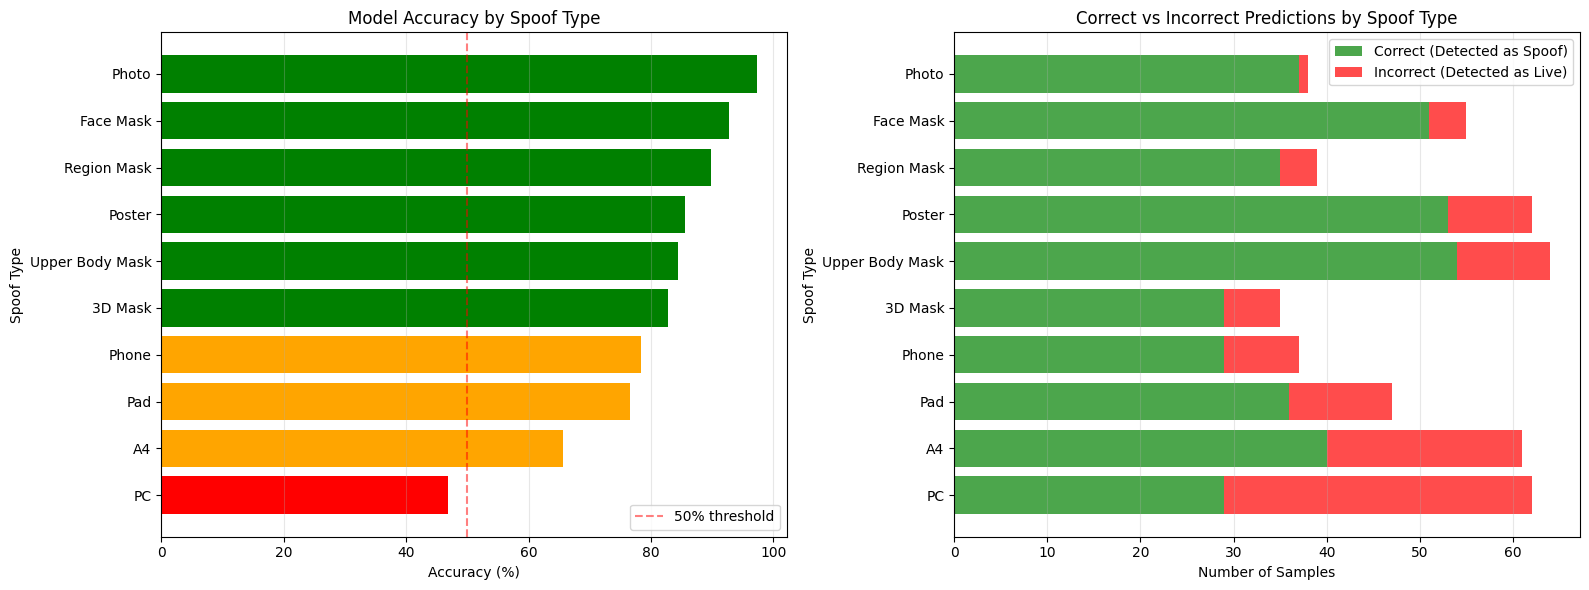


Spoof Type Analysis Results:
     Spoof Type  Type ID  Total  Correct  Incorrect  Accuracy (%)
             PC        7     62       29         33     46.774194
             A4        3     61       40         21     65.573770
            Pad        8     47       36         11     76.595745
          Phone        9     37       29          8     78.378378
        3D Mask       10     35       29          6     82.857143
Upper Body Mask        5     64       54         10     84.375000
         Poster        2     62       53          9     85.483871
    Region Mask        6     39       35          4     89.743590
      Face Mask        4     55       51          4     92.727273
          Photo        1     38       37          1     97.368421


Worst Performing Spoof Types (Accuracy < 70%):
Spoof Type  Type ID  Total  Correct  Incorrect  Accuracy (%)
        PC        7     62       29         33     46.774194
        A4        3     61       40         21     65.573770


In [33]:


# Run the analysis
spoof_analysis_df, spoof_fig = analyze_spoof_types(
    model=model,
    dataset=small_test_ds,
    device=device,
    val_transforms=gpu_transforms_val
)

In [34]:
# Check a few samples
for i in range(5):
    _, label = small_test_ds[i]
    print(f"Sample {i}: Label = {label.item()} ({'Live' if label.item() == 0 else 'Spoof'})")

Sample 0: Label = 0 (Live)
Sample 1: Label = 1 (Spoof)
Sample 2: Label = 0 (Live)
Sample 3: Label = 1 (Spoof)
Sample 4: Label = 1 (Spoof)


In [35]:
# Test with a known Live sample
img, label = small_test_ds[2]  # Adjust index to find a Live sample
print(f"True label: {'Live' if label == 0 else 'Spoof'}")

img = img.unsqueeze(0).to(device)
img = gpu_transforms_val(img)
output = model(img)
pred = torch.argmax(output, dim=1).item()
print(f"Predicted: {'Live' if pred == 0 else 'Spoof'}")

True label: Live
Predicted: Live


Analyzing spoof type distribution...


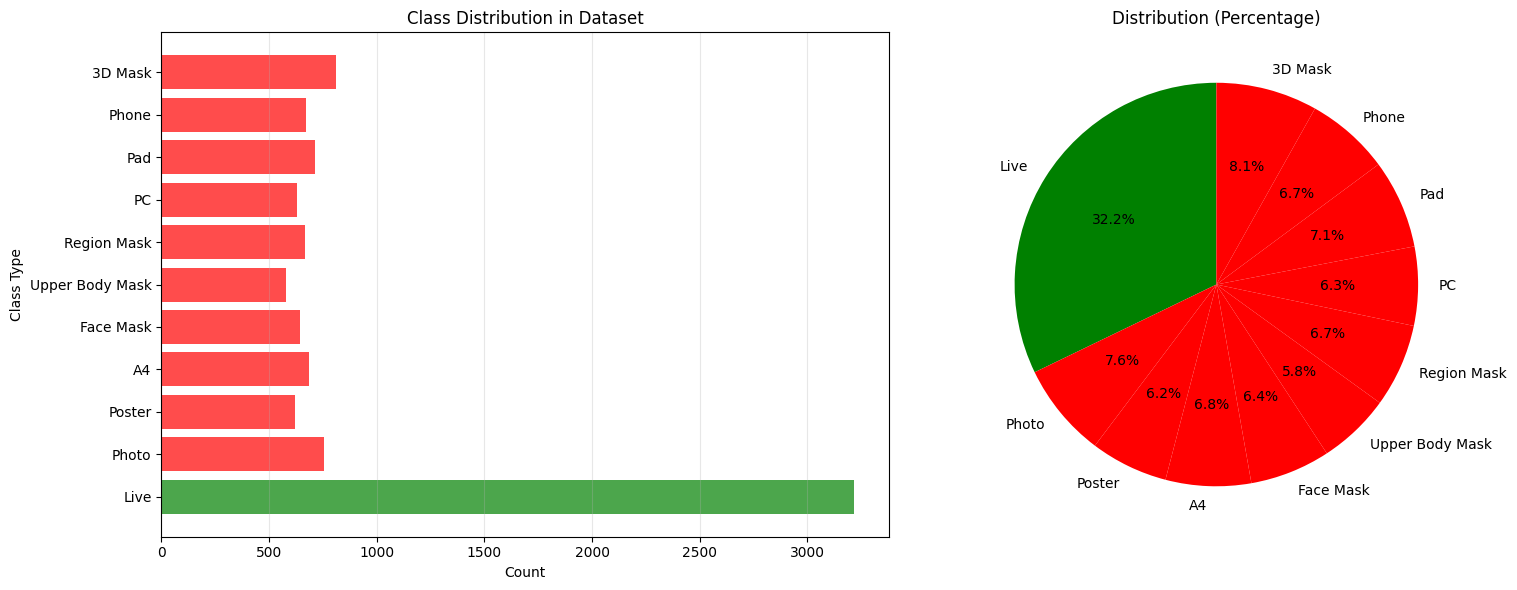


Class Distribution:
     Spoof Type  Type ID  Count  Percentage
           Live        0   3216       32.16
          Photo        1    756        7.56
         Poster        2    622        6.22
             A4        3    684        6.84
      Face Mask        4    644        6.44
Upper Body Mask        5    581        5.81
    Region Mask        6    668        6.68
             PC        7    632        6.32
            Pad        8    712        7.12
          Phone        9    672        6.72
        3D Mask       10    813        8.13


In [36]:


# Analyze training dataset distribution
train_dist_df, train_dist_fig = analyze_dataset_spoof_distribution(small_train_ds)